In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import concurrent.futures
import requests
import itertools
import networkx as nx
from collections import defaultdict
from functools import partial
from tqdm import tqdm
from requests_futures.sessions import FuturesSession
import matplotlib.pyplot as plt
import ast

headers = {"accept": "application/json"}
api_key = "f5813332cb558d374cbcb057ea2fc48b"

In [ ]:
def movie_titles_and_IDs_from_actor_ID(actor_id, session):
    url = f"https://api.themoviedb.org/3/person/{actor_id}/movie_credits?api_key={api_key}"
    response = session.get(url)
    data = response.json()
    # Return the whole movie dictionary, not just the title
    return [movie['title'] for movie in data['cast']], [movie['id'] for movie in data['cast']]

In [ ]:
def fetch_page(page, session):
    url = f"https://api.themoviedb.org/3/person/popular?api_key={api_key}&page={page}"
    response = session.get(url)
    data = response.json()
    people = []
    for person in data['results']:
        person_url = f"https://api.themoviedb.org/3/person/{person['id']}?api_key={api_key}"
        person_response = session.get(person_url)
        person_data = person_response.json()
        people.append((person['name'], person['id'], person_data['gender'], person_data['birthday'], person_data['place_of_birth']))
    return people

with requests.Session() as session:
    session.headers.update(headers)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        pages = list(range(1, 251))
        fetch_page_with_session = partial(fetch_page, session=session)
        people = list(executor.map(fetch_page_with_session, pages))

all_people_names, all_people_ids, all_people_genders, all_people_birthdays, all_people_birthplaces = zip(*itertools.chain(*people))

In [ ]:
# Create a DataFrame with 'actors' column
df_actors = pd.DataFrame(all_people_names, columns=['actors'])

# Add 'ids', 'genders', and 'birthplaces' columns to the DataFrame
df_actors['actor_ids'] = all_people_ids
df_actors['genders'] = all_people_genders
df_actors['ages'] = all_people_birthdays # This is not the age, but the birthday
df_actors['birthplaces'] = all_people_birthplaces

# Change birthplaces so that it only contains the country (text after the last comma)
df_actors['birthplaces'] = df_actors['birthplaces'].str.split(',').str[-1]

# Change birthday to age
df_actors['ages'] = pd.to_datetime(df_actors['ages'], errors='coerce')
df_actors['ages'] = (pd.to_datetime('today') - df_actors['ages']).dt.days // 365

# Drop rows with missing values
df_actors.dropna(inplace=True)

# Drop duplicates
df_actors.drop_duplicates(subset='actors', inplace=True)
#reset index
df_actors.reset_index(drop=True, inplace=True)


In [ ]:
df_actors

In [ ]:
# Fetch movies for each actor and add them to 'movies' and 'movie_IDs' columns
with requests.Session() as session:
    session.headers.update(headers)
    movie_titles_and_ids_from_actor_ID_with_session = partial(movie_titles_and_IDs_from_actor_ID, session=session)
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        movies_and_ids = list(executor.map(movie_titles_and_ids_from_actor_ID_with_session, df_actors['actor_ids']))

# Add 'movies' column to df_actors
df_actors['movies'] = [x[0] for x in movies_and_ids]

# Flatten movies_and_ids into two separate lists
movies = [item for sublist in [x[0] for x in movies_and_ids] for item in sublist]
ids = [item for sublist in [x[1] for x in movies_and_ids] for item in sublist]

# Convert the lists into a list of dictionaries
movies_and_ids_dict = [{'movie': movie, 'movie_ID': id} for movie, id in zip(movies, ids)]

# Convert the list of dictionaries into a DataFrame
movies_df = pd.DataFrame(movies_and_ids_dict)
movies_df = movies_df.drop_duplicates()
movies_df.reset_index(drop=True, inplace=True)

In [ ]:
movies_df

In [ ]:
def fetch(session, url):
    future = session.get(url, headers=headers)
    return future

def fetch_all(urls):
    with FuturesSession() as session:
        futures = [fetch(session, url) for url in urls]
        responses = [future.result().json() for future in futures]
    return responses

In [ ]:
# Prepare the URLs
urls = [f"https://api.themoviedb.org/3/movie/{id}?api_key={api_key}" for id in movies_df["movie_ID"]]
print('urls are prepared')

# Fetch all responses
responses = fetch_all(urls)
print('all responses are fetched')

# Process the responses
for i, response in enumerate(responses):
    if i % 100 == 0:
        print(f"Processing response {i+1}/{len(responses)}")
    if isinstance(response, Exception):
        print(f"Error: {response}")
        continue  # Skip this response
    # Process the response here

# Initialize empty lists to store the data
ratings = []
popularities = []
genres = []
release_dates = []
abstracts = []

# Process the responses one by one
for data in tqdm(responses):
    ratings.append(data.get('vote_average'))
    popularities.append(data.get('popularity'))
    genres.append([genre['name'] for genre in data.get('genres', [])])
    release_dates.append(data.get('release_date'))
    abstracts.append(data.get('overview'))
    
# Assign the lists to the DataFrame columns
movies_df['rating'] = ratings
movies_df['popularity'] = popularities
movies_df['genres'] = genres
movies_df['release_date'] = release_dates
movies_df['abstract'] = abstracts

In [ ]:
movies_df

In [ ]:
# Drop duplicates
movies_df.drop_duplicates(subset='movie', inplace=True)

# Drop rows with missing values
movies_df.dropna(inplace=True)

# Remove rows with empty lists in 'genres' column
movies_df = movies_df[movies_df['genres'].apply(lambda x: len(x) > 0)]

# Remove rows with empty release dates
movies_df = movies_df[movies_df['release_date'].apply(lambda x: len(x) > 0)]

# Drop row if abstract is missing
movies_df = movies_df[movies_df['abstract'].apply(lambda x: len(x) > 0)]

# Drop row if rating is missing
movies_df = movies_df[movies_df['rating'].apply(lambda x: x > 0)]

# Drop row if popularity is missing
movies_df = movies_df[movies_df['popularity'].apply(lambda x: x > 0)]

# Reset index
movies_df.reset_index(drop=True, inplace=True)

In [ ]:
movies_df

In [ ]:
# Combine the two dataframes so that each actor is associated with the movies they have acted in
df_actors_filtered = df_actors.copy()
df_movies_filtered = movies_df.copy()
df_movies_filtered.rename(columns={'movie': 'movies'}, inplace=True)

df_actors_filtered = df_actors_filtered.explode('movies').reset_index(drop=True)

df_actors_movies = df_actors_filtered.merge(df_movies_filtered, on='movies', how='left')

# Remove all rows where the release date is before 2010
df_actors_movies = df_actors_movies[(df_actors_movies['release_date'] >= '2010-01-01') & (df_actors_movies['release_date'] <= '2024-04-16')]

# Collapse the the actors in the actor column so there is only one row per actor and the movies and movie_IDs are stored in lists
df_actors_filtered = df_actors_movies.groupby('actors').agg({'actor_ids': 'first',
                                                             'genders': 'first',
                                                             'birthplaces': 'first',
                                                             'ages': 'first',
                                                             'movies': list, 
                                                             'movie_ID': list}).reset_index()

df_movies_filtered = df_actors_movies.drop_duplicates(subset=['movies']).groupby('movies').agg({'movie_ID': 'first',
                                                                                               'rating': 'first',
                                                                                               'popularity': 'first',
                                                                                               'genres': 'first',
                                                                                               'release_date': 'first',
                                                                                               'abstract': 'first'}).reset_index()

In [ ]:
df_actors_filtered

In [ ]:
df_movies_filtered

In [198]:
import pycountry
import re

# Clean birthplace column in actor dataframe
len_bef_clean = len(df_actors_filtered['birthplaces'].unique())

country_names = [country.name for country in pycountry.countries]

def normalize_country_name(name):
    # strip name
    name = name.strip()
    # replace '.' with ''
    name = name.replace('.', '').replace(']', '')
    if "Türkiye" in name or "Turkey" in name:
        return "Turkey"
    try:
        # Try to get the country object
        country = pycountry.countries.get(name=name)
        if country is not None:
            # If the country object is found, return the official name
            return country.name
        else:
            # If the country object is not found, try to find it by its common name
            country = pycountry.countries.search_fuzzy(name)
            return country[0].name
    except LookupError:
        # Standardizing names
        for country_name in country_names:
            if country_name in name:
                return country_name

        # Fixing abbreviations and wird instances
        if "Russia" in name:
            return "Russian Federation"
        elif "USA" in name or " US" in name or "United States" in name:
            return "United States"
        elif "Korea" in name:
            return "Korea, Republic of"
        elif "UK" in name or "İngiltere" in name:
            return "United Kingdom"
        elif "Czech" in name:
            return "Czechia"
        # Hardcoded, could use package to translate, maybe not necessary, few occurences
        elif "TX" in name:
            return "United States"
        elif "Frankrike" in name:
            return "France"
        elif "Afrique du Sud" in name:
            return "South Africa"
        elif "Irlanda" in name:
            return "Ireland"
        elif "中国" in name or "中华民国" in name or "重庆" in name or "南京" in name:
            return "China"
        
        
        # Updating from old names
        if "now" in name:
            match = re.search(r'\[now (.*?)', name)
            if match:
                return match.group(1)

        # If the country is not found, return the original name
        return name

# Normalize the country names in the DataFrame
df_actors_filtered['birthplaces'] = df_actors_filtered['birthplaces'].apply(normalize_country_name)

len_aft_clean = len(df_actors_filtered['birthplaces'].unique())
print("length before cleaning", len_bef_clean)
print("length after cleaning", len_aft_clean)

length before cleaning 111
length after cleaning 110


In [200]:
# save the dataframes to csv files
df_actors_filtered.to_csv('data/actors.csv', index=False)
df_movies_filtered.to_csv('data/movies.csv', index=False)

### Creating the network

In [190]:
# load the dataframes from csv files
df_actors_filtered = pd.read_csv('data/actors.csv', converters={'movies': ast.literal_eval, 'movie_ID': ast.literal_eval})
df_movies_filtered = pd.read_csv('data/movies.csv', converters={'genres': ast.literal_eval})

In [4]:
# Step 1: Prepare the Data
movie_to_actors = defaultdict(list)

for _ , row in df_actors_filtered.iterrows():
    actor = row['actors']
    movies = row['movies']
    for movie in movies:
        movie_to_actors[movie].append(actor)

edges = defaultdict(int)
for actors in movie_to_actors.values():
    for pair in itertools.combinations(sorted(actors), 2):
        edges[pair] += 1

# Step 2: Create the Graph
G = nx.Graph()

# Add nodes with attributes
for _ , row in df_actors_filtered.iterrows():
    G.add_node(row['actors'], gender=row['genders'], age=row['ages'], birthplace=row['birthplaces'])

# Add edges with weights
for edge, weight in edges.items():

# YAHNI
    if weight >= 2:
        G.add_edge(*edge, weight=weight)

# Step 3: Analyze the Graph
degrees = dict(G.degree(weight='weight'))
most_connected_actors = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

In [5]:
print(G)

Graph with 4589 nodes and 23447 edges


### Initial network analysis

##### Degrees and weights

In [18]:
# Sort the edges by weight in descending order
sorted_edges = sorted(G.edges.data(), key=lambda x: x[2]['weight'], reverse=True)

print("Top 10 most important edges:")
for i, edge in enumerate(sorted_edges[:10], start=1):
    print(f"Rank: {i}, Edge: {edge[0]} - {edge[1]}, Weight: {edge[2]['weight']}")

print("\nTop 10 actors with the highest degree:")
for i, actor in enumerate(most_connected_actors[:10], start=1):
    print(f"Rank: {i}, Actor: {actor[0]}, Degree: {actor[1]}")

Top 10 most important edges:
Rank: 1, Edge: Frank Welker - Grey DeLisle, Weight: 46
Rank: 2, Edge: Adam Copeland - John Cena, Weight: 42
Rank: 3, Edge: Dwayne Johnson - John Cena, Weight: 34
Rank: 4, Edge: Grey DeLisle - Matthew Lillard, Weight: 34
Rank: 5, Edge: Frank Welker - Matthew Lillard, Weight: 33
Rank: 6, Edge: Dee Bradley Baker - Grey DeLisle, Weight: 30
Rank: 7, Edge: Frank Welker - Jeff Bennett, Weight: 30
Rank: 8, Edge: Grey DeLisle - Kevin Michael Richardson, Weight: 28
Rank: 9, Edge: Grey DeLisle - Tara Strong, Weight: 27
Rank: 10, Edge: Grey DeLisle - Jeff Bennett, Weight: 24

Top 10 actors with the highest degree:
Rank: 1, Actor: Grey DeLisle, Degree: 596
Rank: 2, Actor: Samuel L. Jackson, Degree: 576
Rank: 3, Actor: Stan Lee, Degree: 539
Rank: 4, Actor: Frank Welker, Degree: 515
Rank: 5, Actor: Tara Strong, Degree: 497
Rank: 6, Actor: Dee Bradley Baker, Degree: 496
Rank: 7, Actor: Benedict Cumberbatch, Degree: 404
Rank: 8, Actor: Scarlett Johansson, Degree: 393
Rank: 

These are the top ten actors who have participated the most together, as the weight of an edge represents the number of times two actors (nodes) have co-acted in movies together. 

In [15]:
import numpy as np
# Compute node degrees
degrees = dict(G.degree())
weighted_degrees = dict(G.degree(weight='weight'))

# Compute the specificied values
average_degree = np.mean(list(degrees.values()))
median_degree = np.median(list(degrees.values()))
try:
    mode_degree = mode(list(degrees.values())) #Degree value that occurs with highest frequency among the nodes
except:
    mode_degree = "No unique mode"
min_degree = min(degrees.values())
max_degree = max(degrees.values())

# Same calculations but for STRENGTH (WEIGHTED DEGREE)
average_weighted_degree = np.mean(list(weighted_degrees.values()))
median_weighted_degree = np.median(list(weighted_degrees.values()))
try:
    mode_weighted_degree = mode(list(weighted_degrees.values()))
except:
    mode_weighted_degree = "No unique mode"
min_weighted_degree = min(weighted_degrees.values())
max_weighted_degree = max(weighted_degrees.values())

print("Degree Analysis:")
print(f"Average Degree: {average_degree}")
print(f"Median Degree: {median_degree}")
print(f"Mode Degree: {mode_degree}")
print(f"Minimum Degree: {min_degree}")
print(f"Maximum Degree: {max_degree}")

print("\nWeighted Degree Analysis:")
print(f"Average Weighted Degree: {average_weighted_degree}")
print(f"Median Weighted Degree: {median_weighted_degree}")
print(f"Mode Weighted Degree: {mode_weighted_degree}")
print(f"Minimum Weighted Degree: {min_weighted_degree}")
print(f"Maximum Weighted Degree: {max_weighted_degree}")

Degree Analysis:
Average Degree: 10.218784048812378
Median Degree: 3.0
Mode Degree: No unique mode
Minimum Degree: 0
Maximum Degree: 195

Weighted Degree Analysis:
Average Weighted Degree: 25.989540204837656
Median Weighted Degree: 6.0
Mode Weighted Degree: No unique mode
Minimum Weighted Degree: 0
Maximum Weighted Degree: 596


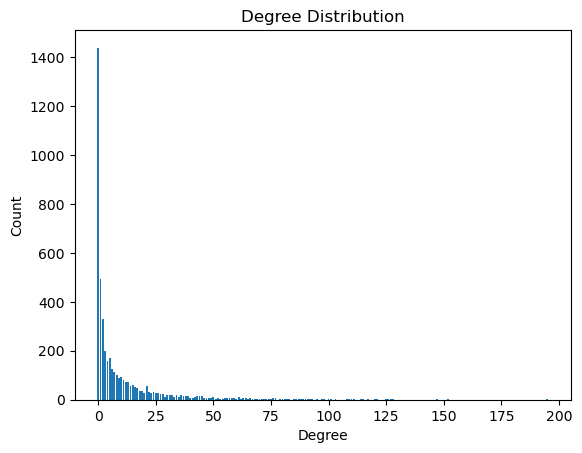

In [7]:
# Calculate degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=False)  # sort in ascending order
degree_count = nx.degree_histogram(G)

# Plot degree distribution
plt.bar(range(len(degree_count)), degree_count, align='center')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution')
plt.show()


Text(0.5, 1.0, 'Degree Distribution (log scale)')

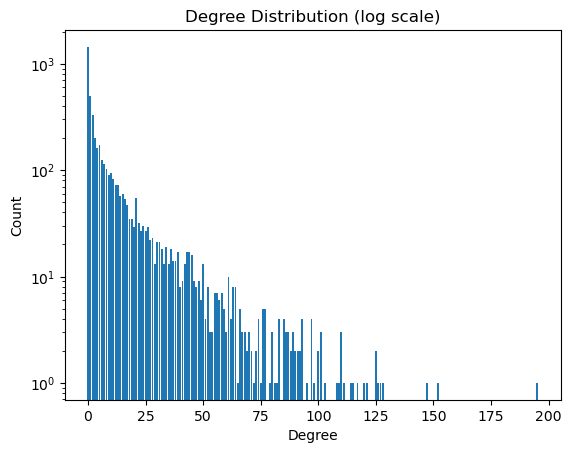

In [8]:
#make a log plot
plt.bar(range(len(degree_count)), degree_count, align='center')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution (log scale)')

In [ ]:
# Plot with netwulf
import netwulf as nw

nw.visualize(G)


### Network analysis

In [9]:
# Calculate the degree assortativity coefficient
assortativity = nx.degree_assortativity_coefficient(G)

assortativity

0.14981105905637299